In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [3]:
# Transformation

transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [4]:
# Load data

batch_size = 32

train_dataset = torchvision.datasets.MNIST(root='../dataset/', train=True, transform=transforms, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='../dataset/', train=False, transform=transforms, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)   

In [5]:
# Define CNN Model

class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.fc1 = nn.Linear(16*7*7, num_classes) # 28 -> 28 -> 14 -> 14 -> 7 (changes due to maxpool)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x) 
        
        return x 

Epoch 1/5, Training Loss: 8.0662, Validation Loss: 2.6695
Accuracy: 0.9742, F1 Score: 0.9742
Epoch 2/5, Training Loss: 2.6793, Validation Loss: 1.8639
Accuracy: 0.9805, F1 Score: 0.9805
Epoch 3/5, Training Loss: 1.9923, Validation Loss: 2.0092
Accuracy: 0.9802, F1 Score: 0.9802
Epoch 4/5, Training Loss: 1.6363, Validation Loss: 1.4337
Accuracy: 0.9860, F1 Score: 0.9860
Epoch 5/5, Training Loss: 1.4142, Validation Loss: 1.5935
Accuracy: 0.9826, F1 Score: 0.9826


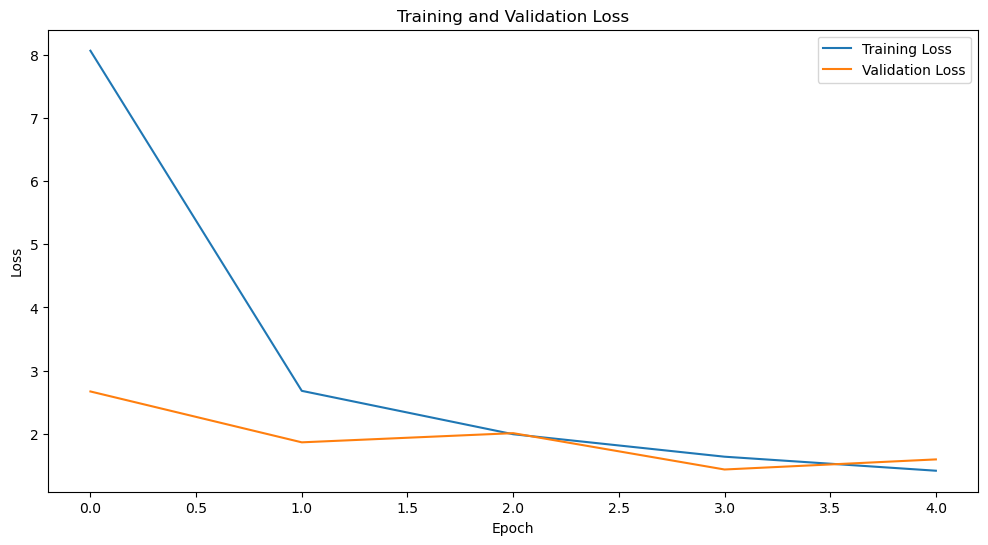

In [6]:
# Training and validation loop

num_epochs = 5
learning_rate = 0.001
train_losses = []
test_losses = []

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X = X.to(device=device)
        y = y.to(device=device)
        optimiser.zero_grad() 
        pred_y = model(X)
        loss = criterion(pred_y, y) # mean loss per sample
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * X.size(0) 
        # running_loss = total loss, X.size() refers to (batch_size, channels, height, width)
    epoch_loss = running_loss/len(train_loader) # epoch_loss refers to mean loss of a sample
    train_losses.append(epoch_loss)

    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device=device)
            y = y.to(device=device)
            pred_y = model(X)
            loss = criterion(pred_y, y)
            running_loss += loss.item() * X.size(0)
            _, preds = torch.max(pred_y, 1) # values and indices
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    epoch_test_loss = running_loss/len(test_loader)
    test_losses.append(epoch_test_loss)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_test_loss:.4f}')
    print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()